## 1. 문제 정의

해양 생태계는 심각한 위기에 직면해 있다. 최근 보고서에 따르면, 해양 생물종의 88%가 플라스틱 쓰레기로 인해 부정적 영향을 받고 있으며, 일부 지역은 회복이 불가능한 정도로 오염되어 있다. 이러한 해양 오염은 인류의 생존 위기와도 연결되어 있다. 국제사회와 각국은 해양 쓰레기로부터 환경 및 생태적 위협을 차단하기 위해 다양한 연대와 협력 체계를 구축하고 있다. 하지만, 시민사회, 기업, 연구기관 등 모든 이들의 노력이 필요하다. 우리는 이제 플라스틱 사용을 줄이고, 대체 제품 개발, 첨단장비 활용 등을 통해 해양 쓰레기 문제를 해결해야 한다. 이는 미래 세대에게 건강한 바다를 물려주는 현 세대의 책무이다.

출처: https://www.hani.co.kr/arti/opinion/because/1054813.html

## 2. 데이터 수집 및 전처리

#(1) 데이터 수집

In [ ]:
# 수집된 이미지가 있으면
# 구글 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

# Google Drive에 있는 img 폴더 경로
not_trash_folder = '/content/drive/MyDrive/인공지능 프로젝트/img/not_trash'
trash_folder = '/content/drive/MyDrive/인공지능 프로젝트/img/trash'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 수집된 이미지가 없다면
# 출판사 제공 깃허브 클론
!git clone https://github.com/2022infotextbook/ai-basic.git

# Google Drive에 있는 img 폴더 경로
not_trash_folder = '/content/ai-basic/4_ai_project/3_pretrained_model_img/not_trash'
trash_folder = '/content/ai-basic/4_ai_project/3_pretrained_model_img/trash'

In [ ]:
import os
from skimage import io

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# 이미지 불러오기
def load_images(folder_path):
    images = []
    for filename in os.listdir(folder_path):
        if filename.endswith(('.png', '.jpg', '.jpeg')):
            img = io.imread(os.path.join(folder_path, filename))
            if img is not None:
                images.append(img)
    return images

# 이미지 데이터 불러오기
not_trash_images = load_images(not_trash_folder)
trash_images = load_images(trash_folder)

print(f'해양생물 이미지 개수: {len(not_trash_images)}')
print(f'해양쓰레기 이미지 개수: {len(trash_images)}')

해양생물 이미지 개수: 20
해양쓰레기 이미지 개수: 44


#(2) 데이터 전처리

In [ ]:
# 이미지 크기 조정
import cv2
from skimage.transform import resize

# 이미지 크기 조정
def resize_images(images, width=128, height=128):
    resized_images = [cv2.resize(img, (width, height)) for img in images]
    return resized_images

not_trash_images = resize_images(not_trash_images)
trash_images = resize_images(trash_images)

정규화 전:


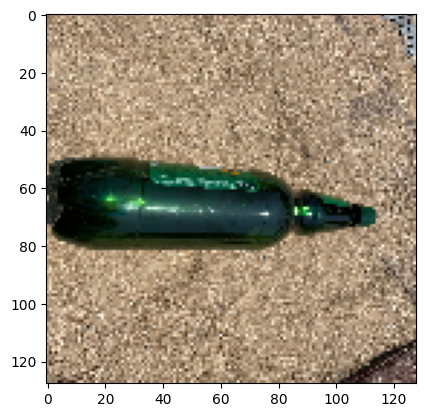

정규화 전 데이터 일부:
[[164 139 112]
 [149 123  98]
 [154 128 103]
 [157 137 113]
 [148 124  96]]
정규화 후:


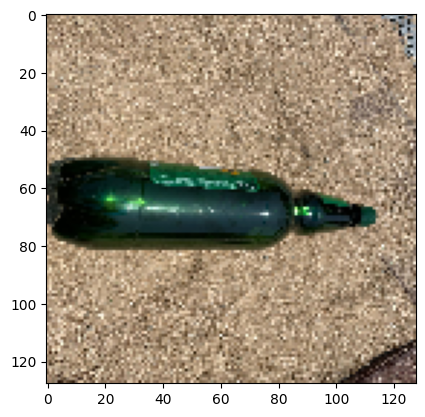

정규화 후 데이터 일부:
[[0.6431373  0.54509807 0.4392157 ]
 [0.58431375 0.48235294 0.38431373]
 [0.6039216  0.5019608  0.40392157]
 [0.6156863  0.5372549  0.44313726]
 [0.5803922  0.4862745  0.3764706 ]]


In [ ]:
# 데이터 정규화
import numpy as np
import matplotlib.pyplot as plt

def normalize_images(images):
    return np.array(images).astype('float32') / 255.0

# 정규화 전 이미지 출력
print("정규화 전:")
plt.imshow(trash_images[0])
plt.show()
print("정규화 전 데이터 일부:")
print(trash_images[0][0, :5])  # 이미지의 첫 행의 첫 5개 픽셀 값 출력

# 정규화
not_trash_images = normalize_images(not_trash_images)
trash_images = normalize_images(trash_images)

# 정규화 후 이미지 출력
print("정규화 후:")
plt.imshow(trash_images[0])
plt.show()
print("정규화 후 데이터 일부:")
print(trash_images[0][0, :5])  # 이미지의 첫 행의 첫 5개 픽셀 값 출력


In [ ]:
# 레이블링
import numpy as np

not_trash_labels = [1] * len(not_trash_images)
trash_labels = [0] * len(trash_images)

# 데이터와 레이블 병합
all_images = np.concatenate(
    (not_trash_images, trash_images), axis=0)
all_labels = np.array(not_trash_labels + trash_labels)

In [ ]:
# 학습용, 테스트용 데이터셋 분할 (80% 학습용, 20% 테스트용)
from sklearn.model_selection import train_test_split

train_images, test_images, train_labels, test_labels = train_test_split(
    all_images, all_labels, test_size=0.2, stratify=all_labels, random_state=42)

print(f'학습용 이미지 개수: {len(train_images)}')
print(f'테스트용 이미지 개수: {len(test_images)}')

학습용 이미지 개수: 51
테스트용 이미지 개수: 13


## 3. 기계학습 유형과 알고리즘 선정

## 4. 기계학습을 통한 모델 생성

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model

# VGG16 모델 불러오기 (사전 훈련된 가중치 포함)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# VGG16 모델의 출력 레이어 정의
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

# 새로운 모델 정의 (VGG16 기반)
model = Model(inputs=base_model.input, outputs=predictions)

# VGG16 모델의 가중치는 변경하지 않도록 설정
for layer in base_model.layers:
    layer.trainable = False

# 모델 컴파일
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 모델 요약
model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                              

In [ ]:
# 모델 학습
epochs = 10
batch_size = 16
history = model.fit(train_images, train_labels, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/10
3/3 [==============================] - 13s 4s/step - loss: 1.1660 - accuracy: 0.6444 - val_loss: 0.0479 - val_accuracy: 1.0000
Epoch 2/10
3/3 [==============================] - 8s 3s/step - loss: 0.1728 - accuracy: 0.9111 - val_loss: 0.0012 - val_accuracy: 1.0000
Epoch 3/10
3/3 [==============================] - 10s 3s/step - loss: 0.0043 - accuracy: 1.0000 - val_loss: 7.0774e-05 - val_accuracy: 1.0000
Epoch 4/10
3/3 [==============================] - 10s 4s/step - loss: 0.0042 - accuracy: 1.0000 - val_loss: 1.3750e-04 - val_accuracy: 1.0000
Epoch 5/10
3/3 [==============================] - 10s 4s/step - loss: 0.0063 - accuracy: 1.0000 - val_loss: 7.5039e-05 - val_accuracy: 1.0000
Epoch 6/10
3/3 [==============================] - 10s 3s/step - loss: 0.0186 - accuracy: 0.9778 - val_loss: 1.5462e-05 - val_accuracy: 1.0000
Epoch 7/10
3/3 [==============================] - 10s 4s/step - loss: 2.4884e-04 - accuracy: 1.0000 - val_loss: 3.2199e-06 - val_accuracy: 1.0000
Epoch 8/10


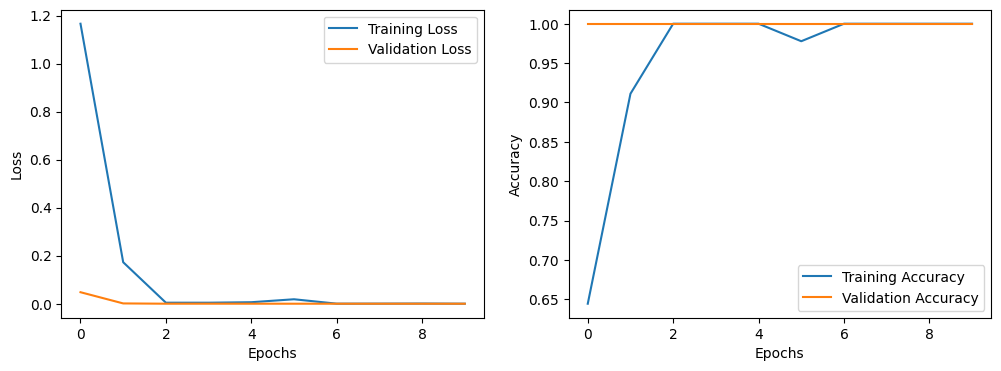

In [ ]:
# 학습 결과 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 5. 성능 평가 및 수정

In [ ]:
# 테스트 데이터 차원 확인 (필요한 경우 수정)
print(f'테스트 이미지 차원: {test_images.shape}')
print(f'테스트 라벨 차원: {test_labels.shape}')

# 모델 성능 평가
test_loss, test_accuracy = model.evaluate(test_images, test_labels)

print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')


테스트 이미지 차원: (13, 128, 128, 3)
테스트 라벨 차원: (13,)
1/1 [==============================] - 2s 2s/step - loss: 3.4731e-06 - accuracy: 1.0000
Test Loss: 3.4731313007796416e-06
Test Accuracy: 1.0


## 6. 직접 해보기

Saving not_trash_189.jpg to not_trash_189.jpg
1/1 [==============================] - 0s 182ms/step


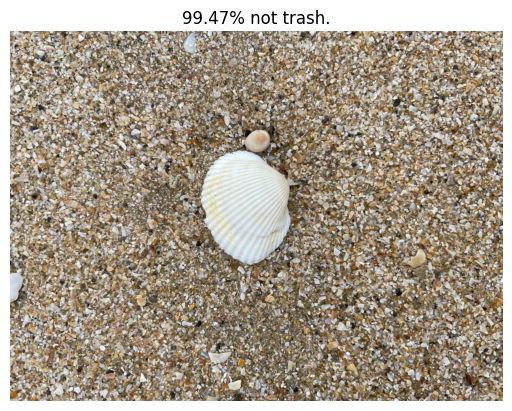

In [ ]:
from google.colab import files
#import os
from skimage import io
from skimage.transform import resize

# 이미지 불러오기 및 전처리
def load_and_preprocess_image(image_path):
    img = io.imread(image_path)
    img = cv2.resize(img, (128, 128))
    img = normalize_images([img])
    return img

# 예측 결과 출력
def display_prediction(image_path, model):
    image = load_and_preprocess_image(image_path)
    prediction = model.predict(image)

    plt.imshow(io.imread(image_path))
    plt.axis('off')

    if prediction >= 0.5:
        plt.title(f'{prediction[0][0] * 100:.2f}% not trash.')
    else:
        plt.title(f'{(1 - prediction[0][0]) * 100:.2f}% trash.')

# 이미지 업로드
uploaded = files.upload()
uploaded_image_path = list(uploaded.keys())[0]

# 예측 결과 확인
display_prediction(uploaded_image_path, model)
